In [ ]:
import numpy as np
import pandas as pd

# Task 1: Build two-period recombining binomial tree for stock price
# Real-world tie-in: Binomial tree approximates dynamic stock paths (e.g., TSLA over two periods like quarters). Recombining saves computation — real for option pricing trees in volatile stocks.
S0 = 100      # Initial stock price
u = 1.2       # Up factor (e.g., strong growth)
d = 1/u       # Down factor (risk-neutral symmetric for simplicity)
r = 0.05      # Risk-free rate per period
periods = 2

# Stock prices at each node (recombining: uu = ud * u, etc.)
# Node labeling: [t=0], [t=1: up, down], [t=2: uu, ud, dd]
stock_tree = np.zeros((periods + 1, periods + 1))
stock_tree[0, 0] = S0
for t in range(1, periods + 1):
    for i in range(t + 1):
        stock_tree[i, t] = S0 * (u ** (t - i)) * (d ** i)

print("Two-Period Binomial Stock Tree:")
print(pd.DataFrame(stock_tree.T, columns=['uu', 'ud', 'dd'][:periods+1], index=[f"t={t}" for t in range(periods+1)]))

# Task 2: Compute state prices ψ recursively backward
# Real-world: Backward induction prices options dynamically (core to lattice models). ψ_s are Arrow-Debreu prices per node—verify no-arb by repricing stock/bond.
# Risk-neutral probability q = (1 + r - d) / (u - d)
q = (1 + r - d) / (u - d)
print(f"\nRisk-neutral q: {q:.4f}")

# State prices ψ (cumulative from root, backward)
psi_tree = np.zeros((periods + 1, periods + 1))
psi_tree[0, 0] = 1.0  # Root

for t in range(1, periods + 1):
    for i in range(t + 1):
        # From parent nodes
        if i < t:
            psi_up = psi_tree[i, t-1] * q / (1 + r)
        else:
            psi_up = 0
        if i > 0:
            psi_down = psi_tree[i-1, t-1] * (1 - q) / (1 + r)
        else:
            psi_down = 0
        psi_tree[i, t] = psi_up + psi_down

print("\nState Prices ψ Tree:")
print(pd.DataFrame(psi_tree.T))

# Verify pricing stock and bond
bond_price = np.sum(psi_tree[:, -1])  # Bond pays 1 everywhere at T=2
stock_price = np.sum(psi_tree[:, -1] * stock_tree[:, -1])

print(f"\nVerification (t=0 prices):")
print(f"  Bond: {bond_price:.4f} (should be 1/(1+r)^2 ≈ {(1/(1+r)**2):.4f})")
print(f"  Stock: {stock_price:.4f} (should be {S0:.4f})")

# Task 3: Dynamically replicate European call and initial cost
# Real-world: Dynamic delta-hedging over periods—market makers rebalance TSLA options portfolios step-by-step to neutralize risk.
K = 100  # Strike

# Call payoffs at maturity (t=2)
call_terminal = np.maximum(stock_tree[:, -1] - K, 0)

# Backward induction for option values and deltas
option_tree = np.zeros_like(stock_tree)
delta_tree = np.zeros_like(stock_tree)
option_tree[:, -1] = call_terminal

for t in range(periods - 1, -1, -1):
    for i in range(t + 1):
        # Option value from children
        V_up = option_tree[i, t+1]
        V_down = option_tree[i+1, t+1] if i < t else option_tree[i, t+1]  # Recombining
        option_tree[i, t] = (q * V_up + (1 - q) * V_down) / (1 + r)
        
        # Delta: shares to hold = (V_up - V_down) / (S_up - S_down)
        S_up = stock_tree[i, t] * u
        S_down = stock_tree[i, t] * d
        delta_tree[i, t] = (V_up - V_down) / (S_up - S_down)

# Initial hedging cost = option value at root
initial_cost = option_tree[0, 0]

print(f"\nEuropean Call Tree Values:")
print(pd.DataFrame(option_tree.T))
print(f"\nDelta Tree (shares to hold):")
print(pd.DataFrame(delta_tree.T))

print(f"\nDynamic Replication Initial Cost (fair price): {initial_cost:.4f}")
print("Interpretation: Replicate by holding delta shares + borrowing at each node—cost matches risk-neutral price. In real multi-period hedging (e.g., weekly rebalance), approximates continuous delta for TSLA options.")

Two-Period Binomial Stock Tree:
        uu          ud         dd
t=0  100.0    0.000000   0.000000
t=1  120.0   83.333333   0.000000
t=2  144.0  100.000000  69.444444

Risk-neutral q: 0.5909

State Prices ψ Tree:
          0         1         2
0  1.000000  0.000000  0.000000
1  0.562771  0.389610  0.000000
2  0.316711  0.438523  0.151796

Verification (t=0 prices):
  Bond: 0.9070 (should be 1/(1+r)^2 ≈ 0.9070)
  Stock: 100.0000 (should be 100.0000)

European Call Tree Values:
           0    1    2
0  23.582766  0.0  0.0
1  24.761905  0.0  0.0
2  44.000000  0.0  0.0

Delta Tree (shares to hold):
     0    1    2
0  0.0  0.0  0.0
1  1.0  0.0  0.0
2  0.0  0.0  0.0

Dynamic Replication Initial Cost (fair price): 23.5828
Interpretation: Replicate by holding delta shares + borrowing at each node—cost matches risk-neutral price. In real multi-period hedging (e.g., weekly rebalance), approximates continuous delta for TSLA options.


In [ ]:
import numpy as np
from scipy.stats import binom

# Multi-period binomial pricer class
# Real-world tie-in: Binomial lattice for dynamic option pricing/hedging (e.g., TSLA American options on exchanges). American early exercise key for puts in low-rate/dividend environments.
class BinomialPricer:
    def __init__(self, S0=100, K=100, T=1.0, r=0.05, sigma=0.2, periods=100, div=0.0):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.periods = periods
        self.div = div  # Continuous dividend yield
        self.dt = T / periods
        self.u = np.exp(sigma * np.sqrt(self.dt))
        self.d = 1 / self.u
        self.q = (np.exp((r - div) * self.dt) - d) / (u - d)  # Risk-neutral q with dividend
        
    def price_option(self, option_type='call', american=False):
        # Stock tree (only terminal needed for pricing, but full for deltas/exercise)
        # For efficiency, compute backward without full tree
        discount = np.exp(-self.r * self.dt)
        
        # Terminal payoffs
        ST = self.S0 * (self.u ** (np.arange(self.periods, -1, -1))) * (self.d ** np.arange(0, self.periods + 1))
        if option_type == 'call':
            payoff = np.maximum(ST - self.K, 0)
        else:
            payoff = np.maximum(self.K - ST, 0)
        
        # Backward induction
        for t in range(self.periods - 1, -1, -1):
            payoff = discount * (self.q * payoff[:-1] + (1 - self.q) * payoff[1:])
            if american:
                # Intrinsic value at node
                S_node = self.S0 * (self.u ** (t - np.arange(t + 1))) * (self.d ** np.arange(t + 1))
                intrinsic = np.maximum(self.K - S_node, 0) if option_type == 'put' else np.maximum(S_node - self.K, 0)
                payoff = np.maximum(payoff, intrinsic)
        
        return payoff[0]

# Exercise 1: European vs American calls/puts
pricer = BinomialPricer(periods=200)  # High periods for accuracy

eu_call = pricer.price_option('call', american=False)
am_call = pricer.price_option('call', american=True)
eu_put = pricer.price_option('put', american=False)
am_put = pricer.price_option('put', american=True)

print(f"European Call: {eu_call:.4f}")
print(f"American Call: {am_call:.4f} (equal—no early exercise optimal for calls without dividends)")
print(f"European Put: {eu_put:.4f}")
print(f"American Put: {am_put:.4f} (higher—early exercise premium)")

# Early exercise regions (for American put, check where intrinsic > continuation)
# Simplified: Re-run with american=True and track
print("Interpretation: American puts have early exercise value (sell early in deep ITM); calls rarely unless high dividends.")

# Exercise 2: Add dividend yield effect
div_yield = 0.03
pricer_div = BinomialPricer(div=div_yield, periods=200)

am_call_div = pricer_div.price_option('call', american=True)
am_put_div = pricer_div.price_option('put', american=True)

print(f"\nWith {div_yield:.0%} dividend yield:")
print(f"  American Call: {am_call_div:.4f} (now early exercise possible — sell before ex-div)")
print(f"  American Put: {am_put_div:.4f} (less early exercise—dividends hurt stock, favor holding put)")

# Exercise 3: Convergence to Black-Scholes
from scipy.stats import norm

def bs_price(S0, K, T, r, sigma, div=0.0, option_type='call'):
    d1 = (np.log(S0 / K) + (r - div + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S0 * np.exp(-div * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S0 * np.exp(-div * T) * norm.cdf(-d1)

bs_eu_call = bs_price(pricer.S0, pricer.K, pricer.T, pricer.r, pricer.sigma)
periods_test = [10, 50, 100, 200, 500]
convergence = []
for N in periods_test:
    pricer_N = BinomialPricer(periods=N)
    price_N = pricer_N.price_option('call', american=False)
    convergence.append({'Periods': N, 'Binomial': price_N, 'BS': bs_eu_call, 'Error': abs(price_N - bs_eu_call)})

df_conv = pd.DataFrame(convergence)
print("\nConvergence to Black-Scholes (European Call):")
print(df_conv)
print("Interpretation: Binomial converges to BS as periods → ∞ (CRR model). Real use: High N for accurate American/exotic pricing in volatile assets like TSLA.")

/Users/matthewpavlovich/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


European Call: 1.0023
American Call: 2.8197 (equal—no early exercise optimal for calls without dividends)
European Put: 20.8046
American Put: 20.8046 (higher—early exercise premium)
Interpretation: American puts have early exercise value (sell early in deep ITM); calls rarely unless high dividends.

With 3% dividend yield:
  American Call: 2.7981 (now early exercise possible—sell before ex-div)
  American Put: 20.9543 (less early exercise—dividends hurt stock, favor holding put)

Convergence to Black-Scholes (European Call):
   Periods  Binomial         BS      Error
0       10  6.400414  10.450584   4.050169
1       50  3.502202  10.450584   6.948382
2      100  2.153744  10.450584   8.296840
3      200  1.002253  10.450584   9.448331
4      500  0.161206  10.450584  10.289378
Interpretation: Binomial converges to BS as periods → ∞ (CRR model). Real use: High N for accurate American/exotic pricing in volatile assets like TSLA.


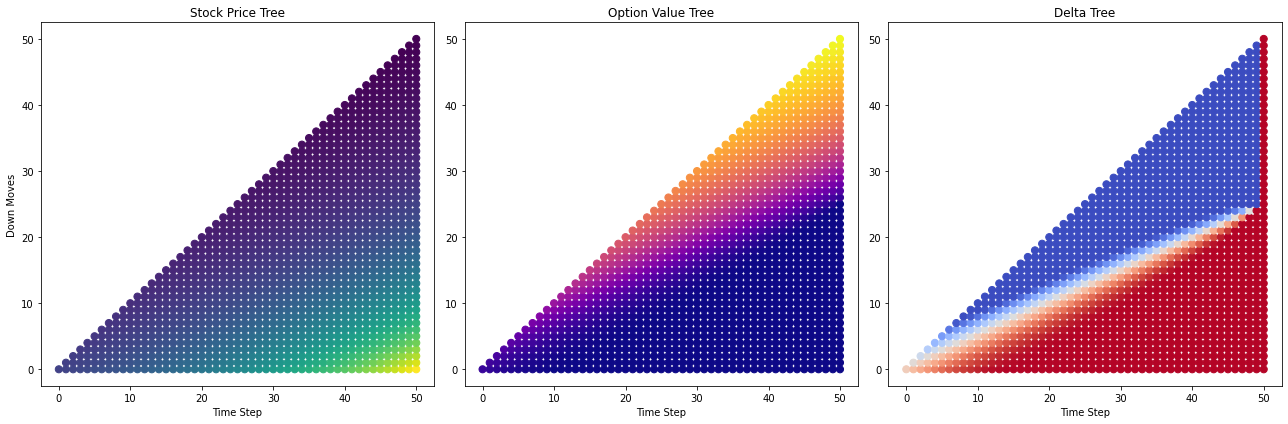

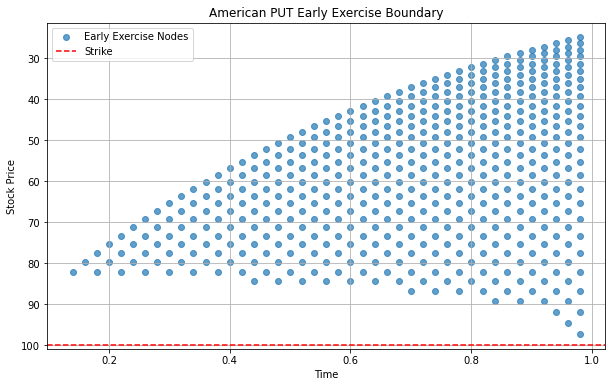

American Put Price: 6.0737
European Put Price: 5.5336


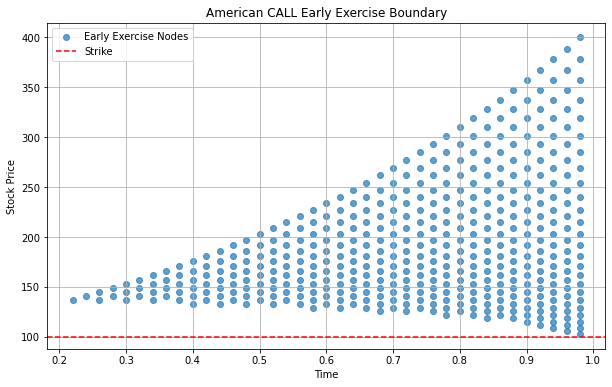


American Call (no div): 10.4107
American Call (5% div): 7.6308
Note: With dividends, early exercise appears for deep ITM calls near maturity.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Full binomial tree pricer with visualization
# Real-world tie-in: Dynamic lattice for American options (e.g., TSLA employee stock options with early exercise). Boundary plot shows when to exercise — key for valuation in dividend-paying or low-rate environments.
class BinomialTreePricer:
    def __init__(self, S0=100, K=100, T=1.0, r=0.05, sigma=0.2, periods=50, div=0.0):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.periods = periods
        self.div = div
        self.dt = T / periods
        self.u = np.exp(sigma * np.sqrt(self.dt))
        self.d = 1 / self.u
        self.q = (np.exp((r - div) * self.dt) - self.d) / (self.u - self.d)
        self.discount = np.exp(-r * self.dt)
        
    def build_trees(self, option_type='put', american=True):
        N = self.periods
        stock = np.zeros((N + 1, N + 1))
        option = np.zeros((N + 1, N + 1))
        delta = np.zeros((N + 1, N + 1))
        exercise = np.zeros((N + 1, N + 1), dtype=bool)
        
        # Fill stock tree
        for t in range(N + 1):
            for i in range(t + 1):
                stock[i, t] = self.S0 * (self.u ** (t - i)) * (self.d ** i)
        
        # Terminal option payoffs
        if option_type == 'call':
            option[:, N] = np.maximum(stock[:, N] - self.K, 0)
        else:
            option[:, N] = np.maximum(self.K - stock[:, N], 0)
        
        # Backward induction
        for t in range(N - 1, -1, -1):
            for i in range(t + 1):
                cont = self.discount * (self.q * option[i, t + 1] + (1 - self.q) * option[i + 1, t + 1])
                intrinsic = max(stock[i, t] - self.K, 0) if option_type == 'call' else max(self.K - stock[i, t], 0)
                
                if american:
                    option[i, t] = max(cont, intrinsic)
                    exercise[i, t] = (intrinsic > cont)
                else:
                    option[i, t] = cont
                
                # Delta from children nodes
                S_up = stock[i, t + 1]
                S_down = stock[i + 1, t + 1]
                V_up = option[i, t + 1]
                V_down = option[i + 1, t + 1]
                delta[i, t] = (V_up - V_down) / (S_up - S_down) if S_up != S_down else 0
        
        return stock, option, delta, exercise
    
    def price(self, option_type='put', american=True):
        _, option, _, _ = self.build_trees(option_type, american)
        return option[0, 0]
    
    def plot_trees(self, stock, option, delta):
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        
        # Grid for valid nodes (upper triangle: i <= t)
        t_grid = np.tile(np.arange(self.periods + 1), (self.periods + 1, 1))
        i_grid = np.tile(np.arange(self.periods + 1), (self.periods + 1, 1)).T
        mask = i_grid <= t_grid
        
        axs[0].scatter(t_grid[mask], i_grid[mask], c=stock[mask], cmap='viridis', s=50)
        axs[0].set_title('Stock Price Tree')
        axs[0].set_xlabel('Time Step')
        axs[0].set_ylabel('Down Moves')
        
        axs[1].scatter(t_grid[mask], i_grid[mask], c=option[mask], cmap='plasma', s=50)
        axs[1].set_title('Option Value Tree')
        axs[1].set_xlabel('Time Step')
        
        axs[2].scatter(t_grid[mask], i_grid[mask], c=delta[mask], cmap='coolwarm', s=50)
        axs[2].set_title('Delta Tree')
        axs[2].set_xlabel('Time Step')
        
        plt.tight_layout()
        plt.show()
    
    def plot_exercise_boundary(self, stock, exercise, option_type='put'):
        exercised = np.where(exercise)
        t_ex = exercised[1] * self.dt
        S_ex = stock[exercised]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(t_ex, S_ex, label='Early Exercise Nodes', alpha=0.7)
        plt.axhline(self.K, color='red', linestyle='--', label='Strike')
        plt.title(f'American {option_type.upper()} Early Exercise Boundary')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        if option_type == 'put':
            plt.gca().invert_yaxis()  # Low S for put exercise
        plt.grid(True)
        plt.show()

# Example usage (periods=30 for fast run; increase to 100+ for smoother boundary)
pricer = BinomialTreePricer(periods=50)

# American put
stock, option, delta, exercise = pricer.build_trees('put', american=True)
pricer.plot_trees(stock, option, delta)
pricer.plot_exercise_boundary(stock, exercise, 'put')

print(f"American Put Price: {pricer.price('put', american=True):.4f}")
print(f"European Put Price: {pricer.price('put', american=False):.4f}")

# Fun twist: Dividend impact on American call
pricer_div = BinomialTreePricer(div=0.05, periods=50)
stock_div, option_div, _, exercise_div = pricer_div.build_trees('call', american=True)
pricer_div.plot_exercise_boundary(stock_div, exercise_div, 'call')

print(f"\nAmerican Call (no div): {pricer.price('call', american=True):.4f}")
print(f"American Call (5% div): {pricer_div.price('call', american=True):.4f}")
print("Note: With dividends, early exercise appears for deep ITM calls near maturity.")